### STAT 301 Final Group Report

In [62]:
library(tidyverse)
library(glmnet)
library(tidymodels)
library(mltools)
library(leaps)
library(car)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

── Attaching packages ────────────────────────────────────── tidymodels 1.2.0 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.2.1     ✔ tune         1.2.1
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.1.0
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ Matrix::expand()  masks tidyr::expand()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ Matrix::pack()    masks tidyr::pack()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
✖ Matrix::unpack()  masks tidyr::unpack()
✖ recipes::update() masks Matrix::update

# Data Description

Data source: https://www.kaggle.com/datasets/saurabhbadole/restaurant-tips-dataset/data

In [11]:
#Read data using reproducible code and from non-local file
tips_df <- read.csv("https://raw.githubusercontent.com/gracieS02/tips-2/refs/heads/main/tips.csv")
head(tips_df)

,total_bill,tip,sex,smoker,day,time,size
,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<int>
1,16.99,1.01,Female,No,Sun,Dinner,2
2,10.34,1.66,Male,No,Sun,Dinner,3
3,21.01,3.50,Male,No,Sun,Dinner,3
4,23.68,3.31,Male,No,Sun,Dinner,2
5,24.59,3.61,Female,No,Sun,Dinner,4
6,25.29,4.71,Male,No,Sun,Dinner,4


The dataset contains 244 observations and 7 variables, collected from a restaurant over time. Each entry represents a unique transaction, detailing bill amount, tip, payer's gender, smoking preference, day, time, and party size, making the data observational since there is no control over variables. Here is a summary table of variables in the dataset:

In [10]:
#Viewing variable types and descriptions in a table
library(knitr)

data <- tibble(
  Variable = c("total_bill", "tip", "sex", "smoker", "day", "time", "size"),
  Type = c("Numeric (float)", "Numeric (float)", "Categorical (string,binary)", "Categorical (string,binary)", 
           "Categorical (string)", "Categorical (string,binary)", "Numeric (integer)"),
  Description = c("Total bill amount (in USD)", "Tip amount (in USD)", "Sex of the customer (Male/Female)",
                  "Whether the customer is a smoker (Yes/No)", "Day of the week (Thur, Fri, Sat, Sun)",
                  "Meal type (Lunch/Dinner)", "Number of people in the dining party (1-6)")
)

kable(data, format = "markdown")



|Variable   |Type                        |Description                                |
|:----------|:---------------------------|:------------------------------------------|
|total_bill |Numeric (float)             |Total bill amount (in USD)                 |
|tip        |Numeric (float)             |Tip amount (in USD)                        |
|sex        |Categorical (string,binary) |Sex of the customer (Male/Female)          |
|smoker     |Categorical (string,binary) |Whether the customer is a smoker (Yes/No)  |
|day        |Categorical (string)        |Day of the week (Thur, Fri, Sat, Sun)      |
|time       |Categorical (string,binary) |Meal type (Lunch/Dinner)                   |
|size       |Numeric (integer)           |Number of people in the dining party (1-6) |

# Exploratory Data Analysis (EDA)

## 1) Data Cleaning and Wrangling

To begin the analysis, the `tips` dataset was loaded and cleaned using the `tidyverse` package.

- Categorical variables (`sex`, `smoker`, `day`, and `time`) were converted into factors for proper handling in plots and summaries.
- Column names were renamed for clarity (e.g., `total_bill` → `bill`, `sex` → `gender`, etc.).
- Missing values were checked for and removed (though none were present).
- A summary of all columns was printed to inspect the distributions and levels of each variable.

This step ensures that the dataset is **tidy, consistent**, and ready for analysis..

In [12]:
# Load the dataset
tips_df <- read_csv("tips.csv")

# Convert categorical variables to factors
tips_df <- tips_df %>%
  mutate(
    sex = as.factor(sex),
    smoker = as.factor(smoker),
    day = as.factor(day),
    time = as.factor(time),
  )

# Rename columns for clarity
tips_df <- tips_df %>%
  rename(
    bill = total_bill,
    gender = sex,
    meal_time = time,
    party_size = size
  )

# Check for missing values
missing_summary <- colSums(is.na(tips_df))
print(missing_summary)

Rows: 244 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): sex, smoker, day, time
dbl (3): total_bill, tip, size

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


      bill        tip     gender     smoker        day  meal_time party_size 
         0          0          0          0          0          0          0 


In [13]:
# Drop NAs (if any) -> none found
tips_df <- tips_df %>%
  drop_na()

# Final summary
summary(tips_df)

      bill            tip            gender    smoker      day      meal_time  
 Min.   : 3.07   Min.   : 1.000   Female: 87   No :151   Fri :19   Dinner:176  
 1st Qu.:13.35   1st Qu.: 2.000   Male  :157   Yes: 93   Sat :87   Lunch : 68  
 Median :17.80   Median : 2.900                          Sun :76               
 Mean   :19.79   Mean   : 2.998                          Thur:62               
 3rd Qu.:24.13   3rd Qu.: 3.562                                                
 Max.   :50.81   Max.   :10.000                                                
   party_size  
 Min.   :1.00  
 1st Qu.:2.00  
 Median :2.00  
 Mean   :2.57  
 3rd Qu.:3.00  
 Max.   :6.00  

## 2) Summary Tables

### A. Table: Observations per Category

In [64]:
tips_df %>%
  count(gender, smoker, day, meal_time) %>%
  arrange(day, meal_time)

gender,smoker,day,meal_time,n
<fct>,<fct>,<fct>,<fct>,<int>
Female,No,Fri,Dinner,1
Female,Yes,Fri,Dinner,4
Male,No,Fri,Dinner,2
Male,Yes,Fri,Dinner,5
Female,No,Fri,Lunch,1
Female,Yes,Fri,Lunch,3
Male,Yes,Fri,Lunch,3
Female,No,Sat,Dinner,13
Female,Yes,Sat,Dinner,15


This table provides a count of observations for each combination of `gender`, `smoker` status, `day`, and `meal_time`.

From the data, we observe that:

- **Most observations occur on the weekend**, especially Saturday and Sunday during dinner time.
- The largest subgroup is **Male, Non-Smoker, Sunday Dinner** with **43 entries**.
- Some combinations, like **Female, Non-Smoker, Friday Lunch**, only have **1 observation**, indicating **sparse or underrepresented groups**.

This information is important for analysis, as small sample sizes in certain subgroups may reduce reliability or cause misleading patterns in visualizations. It also justifies the use of faceting in plots to reveal richer group-wise structure.

### B. Table: Summary Statistics by Group

In [65]:
tips_df %>%
  group_by(day, smoker) %>%
  summarise(
    n = n(),
    avg_bill = round(mean(bill), 2),
    avg_tip = round(mean(tip), 2),
    .groups = "drop"
  )

day,smoker,n,avg_bill,avg_tip
<fct>,<fct>,<int>,<dbl>,<dbl>
Fri,No,4,18.42,2.81
Fri,Yes,15,16.81,2.71
Sat,No,45,19.66,3.10
Sat,Yes,42,21.28,2.88
Sun,No,57,20.51,3.17
Sun,Yes,19,24.12,3.52
Thur,No,45,17.11,2.67
Thur,Yes,17,19.19,3.03


This table shows the average **total bill** and **tip amount** for each combination of `day` and `smoker` status.

Key observations:
- **Sunday** has the highest average total bills overall, particularly among **smokers (\$24.12)**.
- The highest **average tip** also occurs on **Sunday for smokers (\$3.52)**.
- **Smokers tend to leave slightly higher average tips** than non-smokers on **Sunday and Thursday**, but this pattern is not consistent across all days.
- On **Friday**, non-smokers have slightly higher average tips than smokers despite having fewer observations.
- The **difference in averages is relatively small**, suggesting that **smoker status may have a subtle or inconsistent effect** on tipping, but this could be explored further using modeling techniques.

This summary helps highlight **group-level patterns** that inform which variables may be influential in predicting tip behavior.


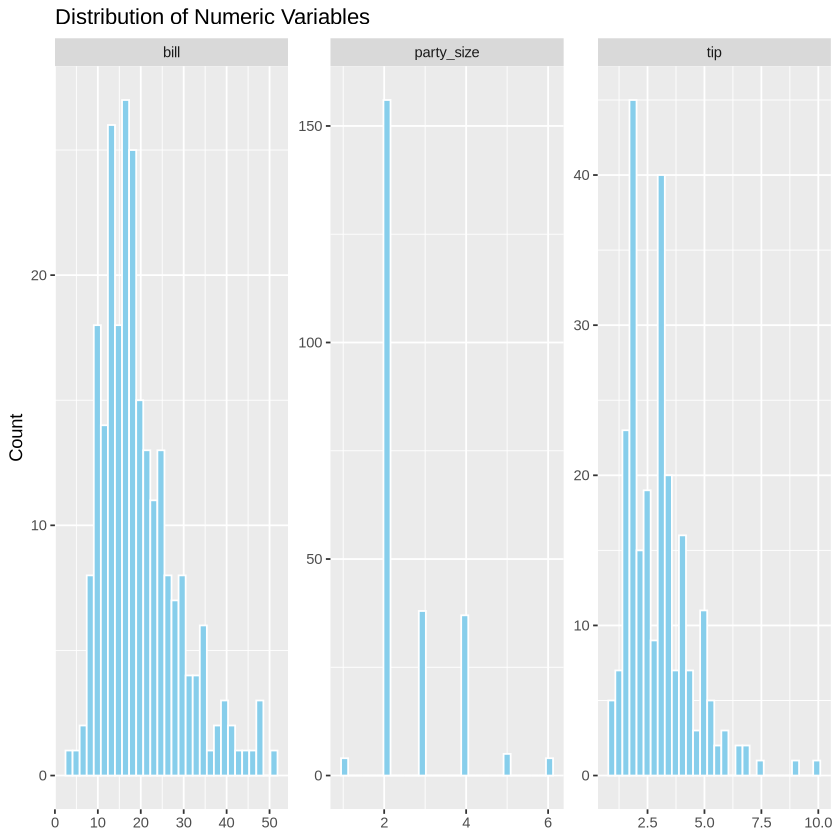

In [27]:

# Filter only numeric variables
tips_long <- tips_df %>%
  select(where(is.numeric)) %>%
  pivot_longer(cols = everything(), names_to = "variable", values_to = "value")

# Plot histograms
ggplot(tips_long, aes(x = value)) +
  geom_histogram(bins = 30, fill = "skyblue", color = "white") +
  facet_wrap(~ variable, scales = "free") +
  labs(title = "Distribution of Numeric Variables", x = NULL, y = "Count")


### C. Summary by Party Size

In [66]:
tips_df %>%
  group_by(party_size) %>%
  summarise(
    count = n(),
    avg_bill = round(mean(bill), 2),
    avg_tip = round(mean(tip), 2),
    .groups = "drop"
  )

party_size,count,avg_bill,avg_tip
<dbl>,<int>,<dbl>,<dbl>
1,4,7.24,1.44
2,156,16.45,2.58
3,38,23.28,3.39
4,37,28.61,4.14
5,5,30.07,4.03
6,4,34.83,5.22


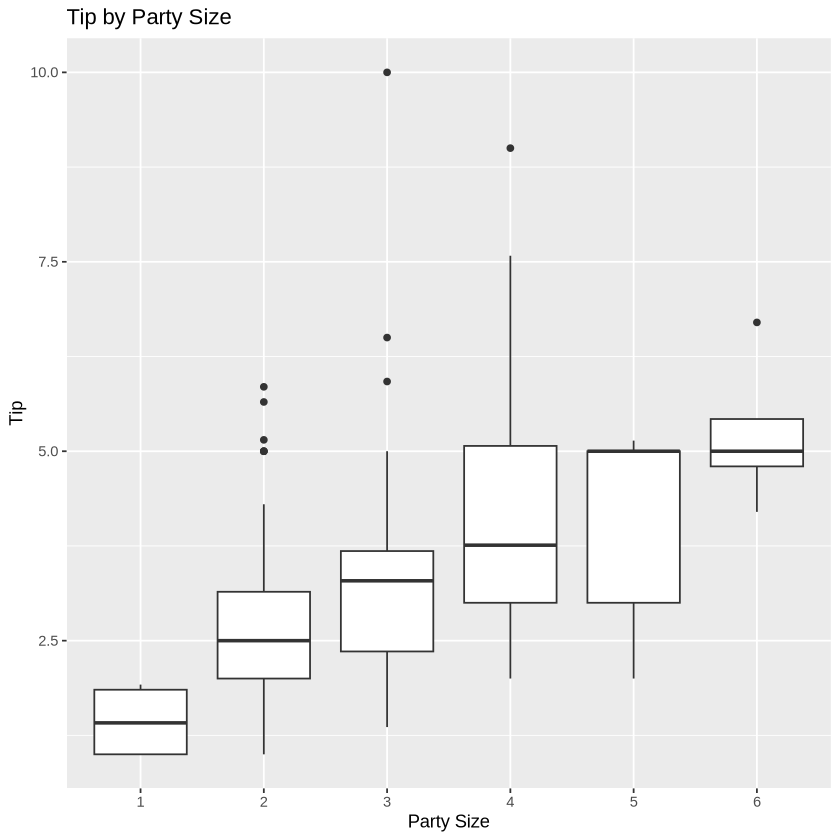

In [24]:
ggplot(tips_df, aes(x = factor(party_size), y = tip)) +
  geom_boxplot() +
  labs(title = "Tip by Party Size", x = "Party Size", y = "Tip")

This table summarizes how **party size** relates to the **average total bill** and **average tip amount**.

Key takeaways:
- As **party size increases**, both **average bill** and **average tip** generally increase.
- For example:
  - A party size of 2 has an average tip of **\$2.58**, while
  - A party of 6 tips an average of **\$5.22** — more than double.
- There is a **clear upward trend**, but...
- The **sample sizes are highly unbalanced**: 156 out of 244 entries are for parties of size 2, while party sizes of 5 or 6 have very few observations (5 and 4, respectively).

This trend raises caution: insights about large party sizes may be **less reliable due to limited data**.


## Check Assumptions of Linear Model

### 1) Check for Linearity and Equal Variance (Homoscedasticity)

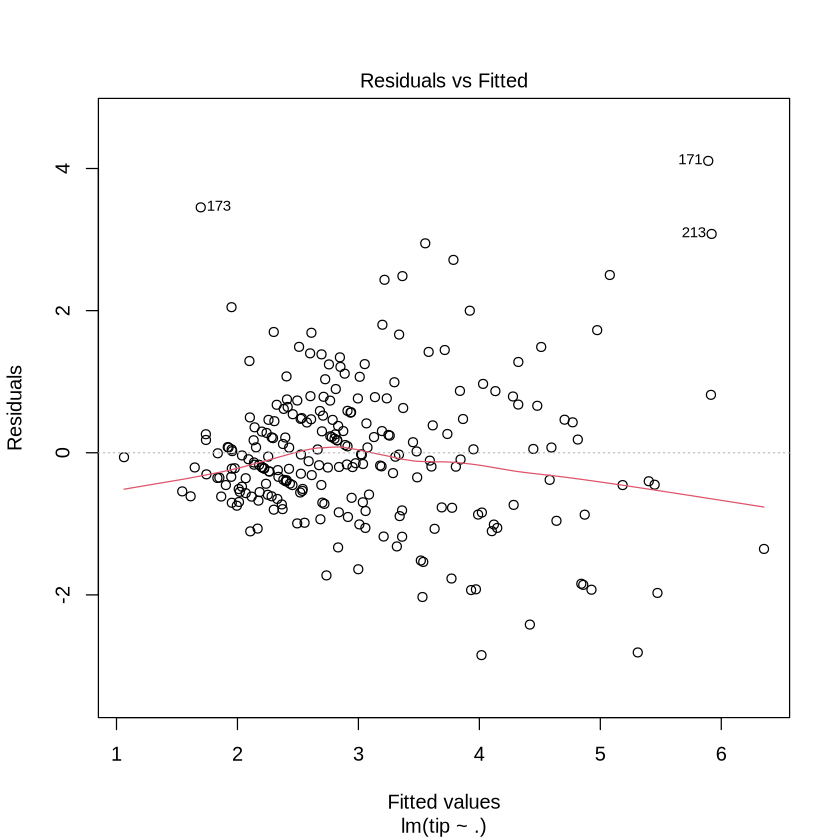

In [14]:
model <- lm(tip ~ ., data = tips_df)
plot(model, which = 1)  # Residuals vs Fitted

In [16]:
### Intepretation of this Residual plot

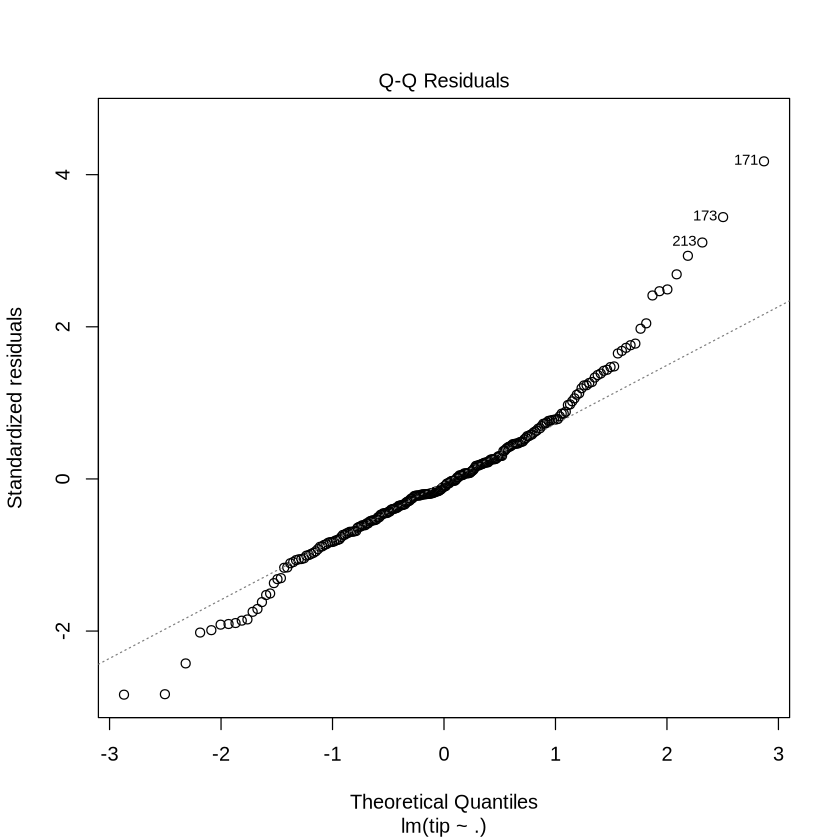

In [17]:
plot(model, which = 2)  # Q-Q plot

In [18]:
## Intepretation of the QQ plot

`geom_smooth()` using formula = 'y ~ x'


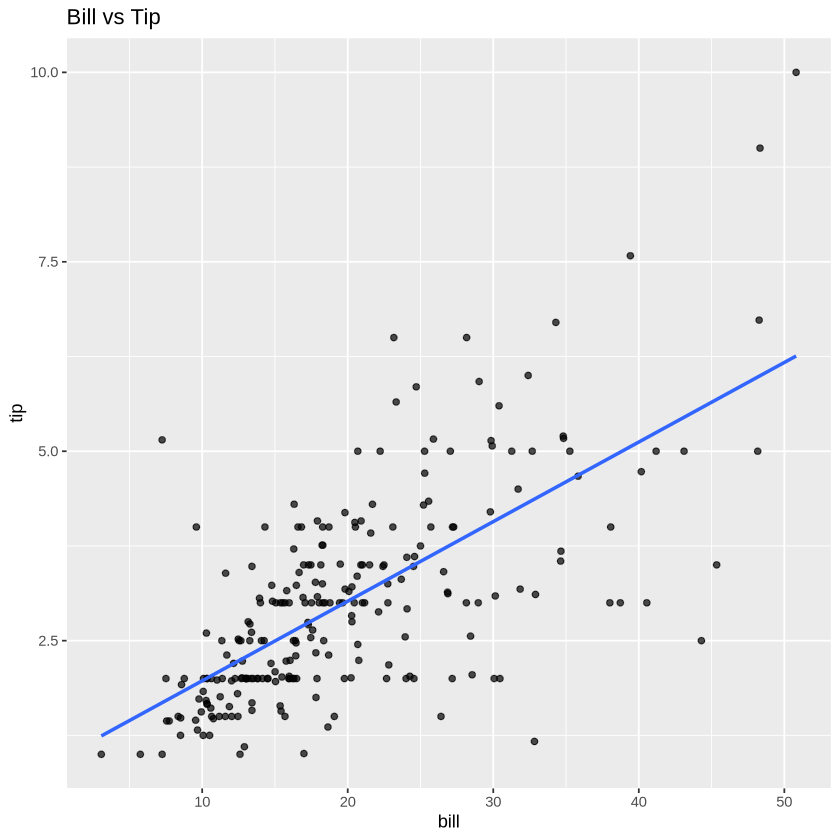

In [20]:
  ggplot(tips_df, aes(x = bill, y = tip)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Bill vs Tip")


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine


`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'
`geom_smooth()` using formula = 'y ~ x'


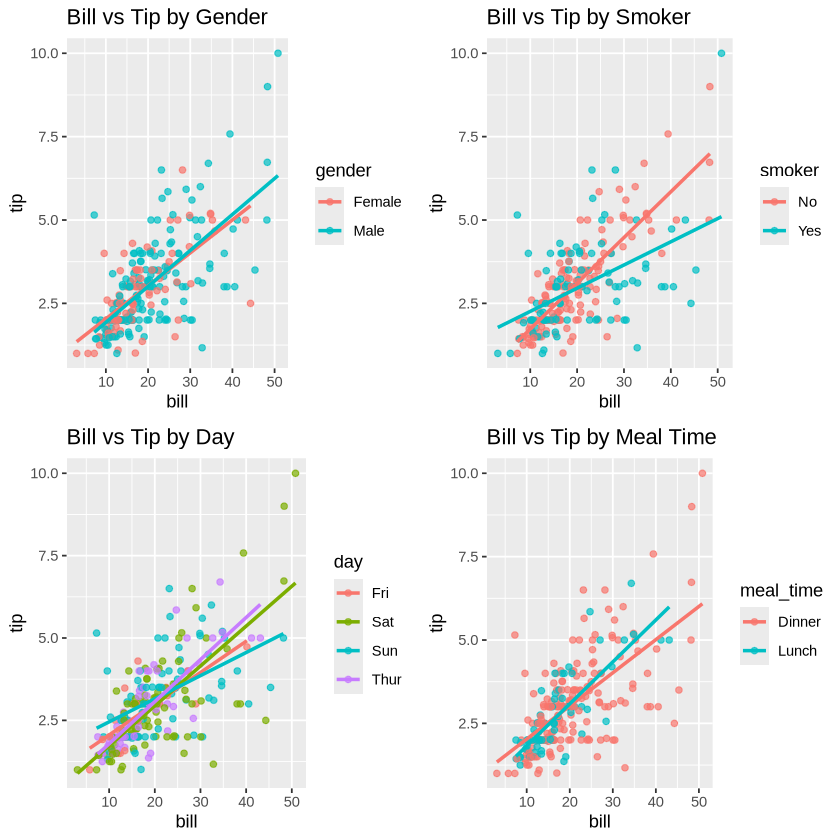

In [19]:
# 1. Bill vs Tip by Gender
p1 <- ggplot(tips_df, aes(x = bill, y = tip, color = gender)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Bill vs Tip by Gender")

# 2. Bill vs Tip by Smoker
p2 <- ggplot(tips_df, aes(x = bill, y = tip, color = smoker)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Bill vs Tip by Smoker")

# 3. Bill vs Tip by Day
p3 <- ggplot(tips_df, aes(x = bill, y = tip, color = day)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Bill vs Tip by Day")

# 4. Bill vs Tip by Meal Time
p4 <- ggplot(tips_df, aes(x = bill, y = tip, color = meal_time)) +
  geom_point(alpha = 0.7) +
  geom_smooth(method = "lm", se = FALSE) +
  labs(title = "Bill vs Tip by Meal Time")

library(gridExtra)
grid.arrange(p1, p2, p3, p4, ncol = 2)

## 3) Visualizations

### Plot 1: Tip vs. Total Bill (Multi-variable Scatterplot)

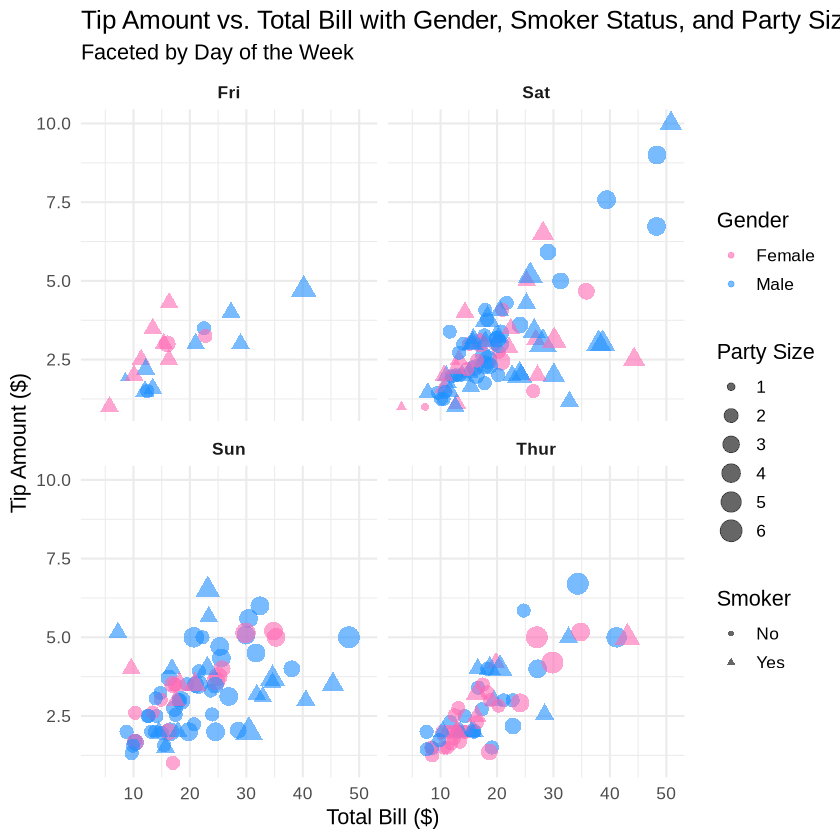

In [67]:
ggplot(tips_df, aes(x = bill, y = tip, color = gender, shape = smoker, size = party_size)) +
  geom_point(alpha = 0.6, stroke = 0.3) +
  facet_wrap(~ day) +
  scale_size_continuous(range = c(2, 6)) +
  scale_color_manual(values = c("Female" = "#FF69B4", "Male" = "#1E90FF")) +
  labs(
    title = "Tip Amount vs. Total Bill with Gender, Smoker Status, and Party Size",
    subtitle = "Faceted by Day of the Week",
    x = "Total Bill ($)",
    y = "Tip Amount ($)",
    color = "Gender",
    shape = "Smoker",
    size = "Party Size"
  ) +
  theme_minimal(base_size = 13) +
  theme(
    legend.position = "right",
    strip.text = element_text(face = "bold")
      )

This scatterplot visualizes the relationship between **total bill** and **tip amount**, incorporating four variables:

- **Color** represents `gender` (pink = Female, blue = Male)
- **Shape** represents `smoker` status (circle = No, triangle = Yes)
- **Size** reflects `party_size` as a numeric variable
- The plot is **faceted by `day` of the week**, allowing for comparison across days

Key observations:
- There is a **positive correlation** between total bill and tip across all days — higher bills generally lead to higher tips.
- Most tips fall in the \$2–5 range, with some **notable outliers** over \$7, especially on **Saturday and Sunday**.
- Larger party sizes (bigger dots) tend to be associated with larger total bills, though not always with higher tips.
- No obvious visual difference appears between **smokers and non-smokers** or **males and females**

This plot is useful because it packs multiple variables into a single view and highlights both general trends and group-based variation. It also reveals that some **party sizes are much less frequent**, which aligns with findings from the summary tables.



### Plot 2: Average Tip Amount by Day and Gender (Heatmap)

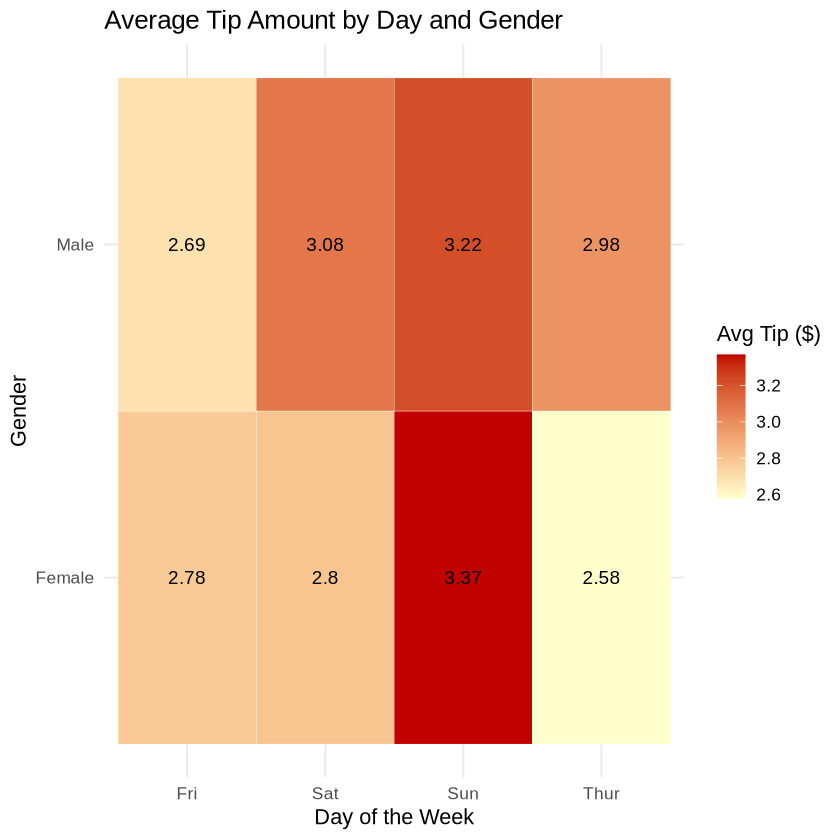

In [68]:
tips_df %>%
  group_by(day, gender) %>%
  summarise(avg_tip = round(mean(tip), 2), .groups = "drop") %>%
  ggplot(aes(x = day, y = gender, fill = avg_tip)) +
  geom_tile(color = "white") +
  geom_text(aes(label = avg_tip), color = "black", size = 4) +
  scale_fill_gradient(low = "#ffffcc", high = "#c10000") +
  labs(
    title = "Average Tip Amount by Day and Gender",
    x = "Day of the Week",
    y = "Gender",
    fill = "Avg Tip ($)"
  ) +
  theme_minimal(base_size = 13)

This heatmap visualizes the **average tip amount** by **gender** and **day of the week**, allowing for comparison of group-level tipping patterns based on gender which wasn't explicitly visible with the scatterplot.

Key takeaways:
- **Sunday** has the highest average tip amounts for both genders:
  - Female: **\$3.37**
  - Male: **\$3.22**
- **Thursday** shows the lowest average tips:
  - Female: **\$2.58**
  - Male: **\$2.98**
- The gender differences are small overall, but **females tip slightly more** than males on Friday and Sunday, while **males tip more** on Thursday and Saturday.

### Conclusion

This exploratory analysis revealed clear relationships between total bill and tip amount, with larger bills generally resulting in higher tips. Group-level patterns showed that tips tend to be highest on weekends, especially Sundays, and that gender and smoker status may play minor roles in tipping behavior. 

By combining individual-level visualizations (scatterplot) with group-level summaries (heatmap), we captured both granular variability and broader trends. These insights can help inform further modeling or guide targeted analyses.


In [71]:
set.seed(1234)

tips_split <- tips |>
    initial_split(prop = 0.7, strata = tip)

tips_train <- training(tips_split)
tips_test <- testing(tips_split)

In [72]:
#tips_step <- stepAIC(lm(tip ~ .,tips))

In [73]:
tips_forward_selection <- regsubsets(x = tip ~ total_bill + sex + smoker + day + size, nvmax = 8,
                                  data = tips_train,
                                  method = "forward")

tips_forward_summary <- summary(tips_forward_selection)
tips_forward_summary

Subset selection object
Call: regsubsets.formula(x = tip ~ total_bill + sex + smoker + day + 
    size, nvmax = 8, data = tips_train, method = "forward")
7 Variables  (and intercept)
           Forced in Forced out
total_bill     FALSE      FALSE
sexMale        FALSE      FALSE
smokerYes      FALSE      FALSE
daySat         FALSE      FALSE
daySun         FALSE      FALSE
dayThur        FALSE      FALSE
size           FALSE      FALSE
1 subsets of each size up to 7
Selection Algorithm: forward
         total_bill sexMale smokerYes daySat daySun dayThur size
1  ( 1 ) "*"        " "     " "       " "    " "    " "     " " 
2  ( 1 ) "*"        " "     " "       " "    " "    " "     "*" 
3  ( 1 ) "*"        " "     "*"       " "    " "    " "     "*" 
4  ( 1 ) "*"        "*"     "*"       " "    " "    " "     "*" 
5  ( 1 ) "*"        "*"     "*"       " "    "*"    " "     "*" 
6  ( 1 ) "*"        "*"     "*"       "*"    "*"    " "     "*" 
7  ( 1 ) "*"        "*"     "*"       "*"    "

n_input_variables,RSQ,RSS,ADJ.R2
<int>,<dbl>,<dbl>,<dbl>
1,0.5088118,170.3694,0.5058528
2,0.5164914,167.7057,0.5106307
3,0.5186569,166.9547,0.5098518
4,0.5196344,166.6156,0.5078463
5,0.5196752,166.6014,0.5048504
6,0.5197377,166.5798,0.5018397
7,0.5197693,166.5688,0.4987592


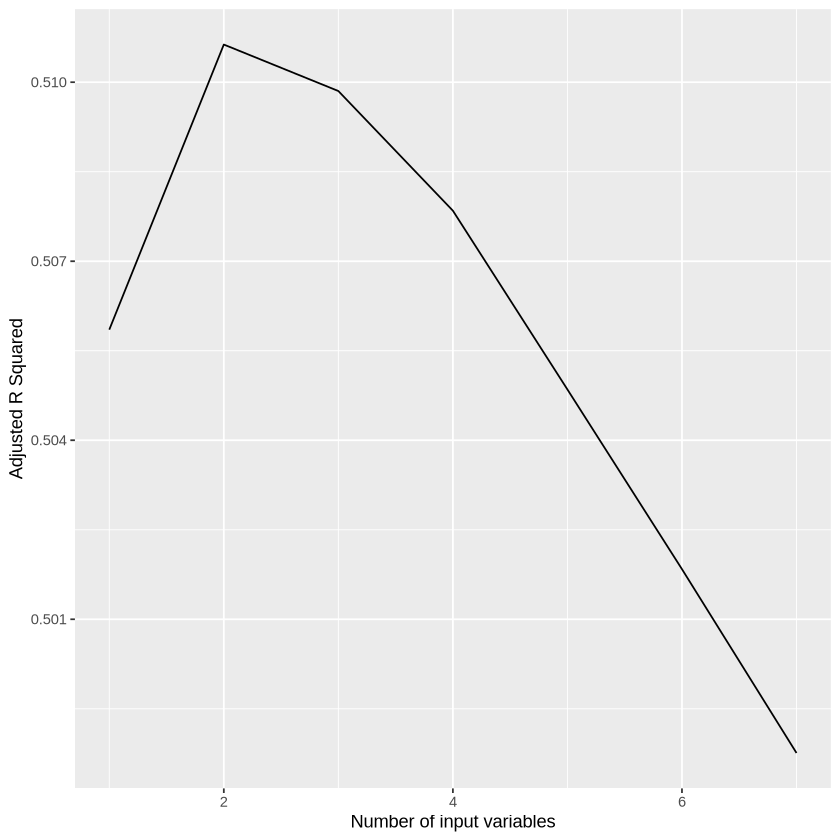

In [74]:
tips_fwd_summary_df <- 
    tibble(
        n_input_variables = 1:7,
        RSQ = tips_forward_summary$rsq,
        RSS = tips_forward_summary$rss,
        ADJ.R2 = tips_forward_summary$adjr2
    )
tips_fwd_summary_df
ggplot(tips_fwd_summary_df,aes(x =  n_input_variables,y = ADJ.R2)) +
geom_line() + 
labs(x = "Number of input variables",
     y = "Adjusted R Squared",)

In [75]:
vif(lm(tip ~ ., tips_train))

,GVIF,Df,GVIF^(1/(2*Df))
total_bill,1.698853,1,1.303400
sex,1.127794,1,1.061977
smoker,1.172588,1,1.082861
day,11.956322,3,1.512166
time,10.747515,1,3.278340
size,1.656404,1,1.287014


In [76]:
tips_linear_model <- lm(tip ~ total_bill + size, tips_test)

In [77]:
anova(lm(tip ~ 1, tips_test),tips_linear_model)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,75,117.67307,NA,NA,NA,NA
2,73,76.67159,2,41.00148,19.51902,1.619737e-07


In [78]:
anova(tips_linear_model, lm(tip ~ ., tips_test))

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,73,76.67159,NA,NA,NA,NA
2,67,72.02565,6,4.645938,0.7202939,0.6346344


In [79]:
tidy(tips_linear_model)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),0.92514056,0.3498233,2.644594,0.0100074031
total_bill,0.06557151,0.0186871,3.508918,0.0007745505
size,0.28154416,0.1502867,1.873381,0.0650189193
